In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
#import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
import seaborn as sns

#### Admissions table

In [2]:
ADMISSIONS = pd.read_csv('ADMISSIONS.csv')

In [3]:
ICUSTAYS = pd.read_csv('ICUSTAYS.csv')
ICUSTAYS.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,2.8939
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0600
4,369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,1.6202


In [4]:
print('Dataset has {} number of unique admission events.'.format(ADMISSIONS['HADM_ID'].nunique()))
print('Dataset has {} number of unique patients.'.format(ADMISSIONS['SUBJECT_ID'].nunique()))

Dataset has 58976 number of unique admission events.
Dataset has 46520 number of unique patients.


In [5]:
ADMISSIONS.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


### Calculate length of stay 
#### ADMISSIONS.csv

In [6]:
ADMISSIONS['ADMITTIME'] = pd.to_datetime(ADMISSIONS['ADMITTIME'])
ICUSTAYS['INTIME']= pd.to_datetime(ICUSTAYS['INTIME'])
ADMISSIONS['DISCHTIME'] = pd.to_datetime(ADMISSIONS['DISCHTIME'])

# ICU in time, hospital out time
ADMISSIONS['LOS(ICU)'] = (ADMISSIONS['DISCHTIME'] - 
                     ICUSTAYS['INTIME']).dt.total_seconds()/86400
ADMISSIONS['LOS'] = (ADMISSIONS['DISCHTIME'] - 
                     ADMISSIONS['ADMITTIME']).dt.total_seconds()/86400


In [7]:
ADMISSIONS[['ADMITTIME', 'DISCHTIME', 'LOS','LOS(ICU)']].head()

,ADMITTIME,DISCHTIME,LOS,LOS(ICU)
0,2196-04-09 12:26:00,2196-04-10 15:54:00,1.144444,-675.315023
1,2153-09-03 07:15:00,2153-09-08 19:10:00,5.496528,-6266.663530
2,2157-10-18 19:34:00,2157-10-25 14:00:00,6.768056,10714.954630
3,2139-06-06 16:14:00,2139-06-09 12:48:00,2.856944,6879.566181
4,2160-11-02 02:06:00,2160-11-05 14:55:00,3.534028,-9546.259074


In [8]:
ADMISSIONS['LOS'].describe()

count    58976.000000
mean        10.133916
std         12.456682
min         -0.945139
25%          3.743750
50%          6.467014
75%         11.795139
max        294.660417
Name: LOS, dtype: float64

In [9]:
ADMISSIONS['LOS(ICU)'].describe()

count    58976.000000
mean        16.265814
std      15068.665128
min     -38017.982222
25%     -10803.406224
50%        -14.484253
75%      10847.442737
max      38066.566331
Name: LOS(ICU), dtype: float64

In [10]:
ADMISSIONS[ADMISSIONS['LOS'] < 0]

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,LOS(ICU),LOS
425,534,417,102633,2177-03-23 16:17:00,2177-03-23 07:20:00,2177-03-23 07:20:00,URGENT,PHYS REFERRAL/NORMAL DELI,DEAD/EXPIRED,Private,...,UNOBTAINABLE,MARRIED,WHITE,NaN,NaN,ORGAN DONOR ACCOUNT,1,1,11088.675880,-0.372917
456,237,181,102631,2153-10-12 09:49:00,2153-10-12 06:29:00,2153-10-12 06:29:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Private,...,PROTESTANT QUAKER,MARRIED,WHITE,2153-10-12 06:23:00,2153-10-12 07:45:00,DISSECTING ANEURYSIM,1,1,-11411.315278,-0.138889
692,644,516,187482,2197-07-31 20:18:00,2197-07-31 01:10:00,2197-07-31 01:10:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,...,JEWISH,WIDOWED,UNKNOWN/NOT SPECIFIED,2197-07-31 11:31:00,2197-07-31 14:35:00,RESPIRATORY DISTRESS,1,0,5672.431968,-0.797222
1911,1640,1334,138015,2137-09-02 14:43:00,2137-09-02 12:00:00,2137-09-02 12:00:00,NEWBORN,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Private,...,PROTESTANT QUAKER,NaN,WHITE,NaN,NaN,NEWBORN,1,1,-22615.297234,-0.113194
1970,1699,1381,181430,2189-01-02 14:25:00,2189-01-02 12:00:00,2189-01-02 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,...,UNOBTAINABLE,MARRIED,WHITE,2189-01-02 10:31:00,2189-01-02 15:56:00,STROKE;TELEMETRY,1,1,21602.566586,-0.100694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57233,57980,96810,165589,2103-09-25 20:38:00,2103-09-25 12:00:00,2103-09-25 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,...,UNOBTAINABLE,WIDOWED,WHITE,2103-09-25 19:27:00,2103-09-25 21:37:00,CARDIAC ARREST,1,1,-3161.085498,-0.359722
57559,58635,98943,193747,2164-11-14 20:03:00,2164-11-14 12:00:00,2164-11-14 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,...,UNOBTAINABLE,MARRIED,WHITE,2164-11-14 18:24:00,2164-11-14 20:54:00,INTRACRANIAL HEMORRHAGE,1,1,-6138.678264,-0.335417
57902,58720,99207,191004,2143-07-06 19:59:00,2143-07-06 12:00:00,2143-07-06 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,...,CATHOLIC,DIVORCED,WHITE,2143-07-06 19:30:00,2143-07-06 20:05:00,GSW L. CHEST WALL & ABDOMEN,1,1,13398.732708,-0.332639
58346,55950,90642,101946,2122-04-24 14:36:00,2122-04-24 12:00:00,2122-04-24 12:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,...,CATHOLIC,MARRIED,UNABLE TO OBTAIN,NaN,NaN,ST-SEGMENT ELEVATION MYOCARDIAL INFARCTION\CATH,1,1,-387.064132,-0.108333


In [11]:
ADMISSIONS = ADMISSIONS[ADMISSIONS['LOS'] > 0]

In [12]:
ADMISSIONS['LOS'].describe()

count    58878.000000
mean        10.151266
std         12.459774
min          0.001389
25%          3.755556
50%          6.489583
75%         11.805556
max        294.660417
Name: LOS, dtype: float64

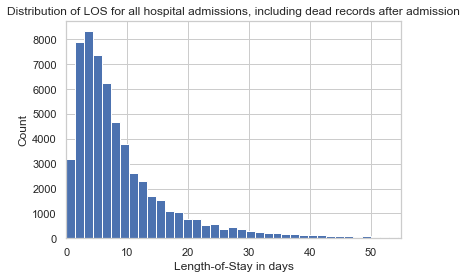

In [13]:
sns.set(style="whitegrid")
plt.hist(ADMISSIONS['LOS'], bins=200)
plt.xlim(0, 55)
plt.title('Distribution of LOS for all hospital admissions, including dead records after admission')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay in days')
plt.tick_params(top=False, right=False) 
plt.show()

#### Now consider who died after admission


In [14]:
# 1: died, 0: not dead.
ADMISSIONS['DECEASED'] = ADMISSIONS['DEATHTIME'].notnull().map({True:1, False:0})

In [15]:
ADMISSIONS.head(10)

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,LOS(ICU),LOS,DECEASED
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,-675.315023,1.144444,0
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,-6266.663530,5.496528,0
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1,10714.954630,6.768056,0
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,...,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1,6879.566181,2.856944,0
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,...,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1,-9546.259074,3.534028,0
5,26,26,197661,2126-05-06 15:16:00,2126-05-13 15:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,...,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,V-TACH,0,1,-5454.633391,6.988889,0
6,27,27,134931,2191-11-30 22:16:00,2191-12-03 14:45:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,NaN,WHITE,NaN,NaN,NEWBORN,0,1,28281.677963,2.686806,0
7,28,28,162569,2177-09-01 07:15:00,2177-09-06 16:00:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,2526.188275,5.364583,0
8,29,30,104557,2172-10-14 14:17:00,2172-10-19 14:37:00,NaN,URGENT,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,MARRIED,UNKNOWN/NOT SPECIFIED,NaN,NaN,UNSTABLE ANGINA\CATH,0,1,9100.232373,5.013889,0
9,30,31,128652,2108-08-22 23:27:00,2108-08-30 15:00:00,2108-08-30 15:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,...,MARRIED,WHITE,NaN,NaN,STATUS EPILEPTICUS,1,1,-8818.258171,7.647917,1


In [16]:
print("{} of {} patients died in the hospital"
      .format(ADMISSIONS['DECEASED'].sum(), ADMISSIONS['SUBJECT_ID']
              .nunique()))

5774 of 46445 patients died in the hospital


In [17]:

ADMISSIONS['LOS'].loc[ADMISSIONS['DECEASED'] == 0].describe()

count    53104.000000
mean        10.138174
std         12.284461
min          0.014583
25%          3.866667
50%          6.565972
75%         11.711632
max        294.660417
Name: LOS, dtype: float64

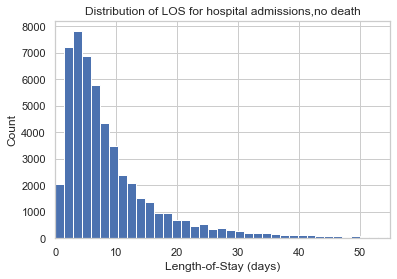

In [18]:
sns.set(style="whitegrid")
plt.hist(ADMISSIONS['LOS'].loc[ADMISSIONS['DECEASED'] == 0], bins=200)
plt.xlim(0, 55)
plt.title('Distribution of LOS for hospital admissions,no death')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show()

### ETHNICITY

In [19]:
ADMISSIONS['ETHNICITY'].value_counts()

WHITE                                                       40939
BLACK/AFRICAN AMERICAN                                       5434
UNKNOWN/NOT SPECIFIED                                        4502
HISPANIC OR LATINO                                           1693
ASIAN                                                        1508
OTHER                                                        1507
UNABLE TO OBTAIN                                              809
PATIENT DECLINED TO ANSWER                                    559
ASIAN - CHINESE                                               277
HISPANIC/LATINO - PUERTO RICAN                                232
BLACK/CAPE VERDEAN                                            200
WHITE - RUSSIAN                                               164
MULTI RACE ETHNICITY                                          130
BLACK/HAITIAN                                                 101
ASIAN - ASIAN INDIAN                                           85
WHITE - OT

#### Diagnosis_ICD.csv

In [20]:
DIAGNOSES_ICD = pd.read_csv('DIAGNOSES_ICD.csv')

In [21]:
DIAGNOSES_ICD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651047 entries, 0 to 651046
Data columns (total 5 columns):
ROW_ID        651047 non-null int64
SUBJECT_ID    651047 non-null int64
HADM_ID       651047 non-null int64
SEQ_NUM       651000 non-null float64
ICD9_CODE     651000 non-null object
dtypes: float64(1), int64(3), object(1)
memory usage: 24.8+ MB


In [22]:
print('There are {} unique ICD9 codes in this dataset.'
      .format(DIAGNOSES_ICD['ICD9_CODE']
              .value_counts().count()))

There are 6984 unique ICD9 codes in this dataset.


In [23]:
DIAGNOSES_ICD.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


In [24]:
DIAGNOSES_ICD['recode'] = DIAGNOSES_ICD['ICD9_CODE']
DIAGNOSES_ICD['recode'] = DIAGNOSES_ICD['recode'][~DIAGNOSES_ICD['recode'].str.contains("[a-zA-Z]").fillna(False)]
DIAGNOSES_ICD['recode'].fillna(value='999', inplace=True)
DIAGNOSES_ICD['recode'] = DIAGNOSES_ICD['recode'].str.slice(start=0, stop=3, step=1)
DIAGNOSES_ICD['recode'] = DIAGNOSES_ICD['recode'].astype(int)

In [25]:
DIAGNOSES_ICD.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,recode
0,1297,109,172335,1.0,40301,403
1,1298,109,172335,2.0,486,486
2,1299,109,172335,3.0,58281,582
3,1300,109,172335,4.0,5855,585
4,1301,109,172335,5.0,4254,425


In [26]:
icd9_cat_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), 
                   (290, 320), (320, 390), (390, 460), (460, 520), 
                   (520, 580), (580, 630), (630, 680), (680, 710),
                   (710, 740), (740, 760), (760, 780), (780, 800),
                   (800, 1000), (1000, 2000)]

In [27]:
len(icd9_cat_ranges)

18

In [28]:
diag_cat_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 
                 3: 'blood',
                 4: 'mental', 5: 'nervous', 
                 6: 'circulatory', 7: 'respiratory',8: 'digestive', 
                 9: 'genitourinary', 10: 'pregnancy', 
                 11: 'skin', 12: 'muscular', 13: 'congenital',
                 14: 'prenatal', 15: 'misc', 16: 'injury', 17: 'misc'}

In [29]:
for i, cat_range in enumerate(icd9_cat_ranges):
    DIAGNOSES_ICD['recode'] = np.where(DIAGNOSES_ICD['recode'].between(cat_range[0],cat_range[1]), 
                                                            i, DIAGNOSES_ICD['recode'])
    
# Convert integer to category name using diag_dict
DIAGNOSES_ICD['recode'] = DIAGNOSES_ICD['recode']
DIAGNOSES_ICD['category'] = DIAGNOSES_ICD['recode'].replace(diag_cat_dict)

In [30]:
DIAGNOSES_ICD

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,recode,category
0,1297,109,172335,1.0,40301,6,circulatory
1,1298,109,172335,2.0,486,7,respiratory
2,1299,109,172335,3.0,58281,9,genitourinary
3,1300,109,172335,4.0,5855,9,genitourinary
4,1301,109,172335,5.0,4254,6,circulatory
...,...,...,...,...,...,...,...
651042,639798,97503,188195,2.0,20280,1,neoplasms
651043,639799,97503,188195,3.0,V5869,16,injury
651044,639800,97503,188195,4.0,V1279,16,injury
651045,639801,97503,188195,5.0,5275,8,digestive


In [31]:
hadm_total = DIAGNOSES_ICD.groupby('HADM_ID')['category'].apply(list).reset_index()
hadm_total.head()

,HADM_ID,category
0,100001,"[endocrine, nervous, genitourinary, digestive,..."
1,100003,"[digestive, blood, infectious, digestive, circ..."
2,100006,"[respiratory, respiratory, respiratory, neopla..."
3,100007,"[digestive, digestive, injury, respiratory, ci..."
4,100009,"[circulatory, injury, circulatory, endocrine, ..."


In [32]:
hadm_sep = pd.get_dummies(hadm_total['category'].apply(pd.Series).stack()).sum(level=0)
hadm_sep.head()

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,0,2,0,2,5,2,0,2,0,0,0,0,2,0,0,0,1
1,1,2,0,4,0,0,1,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,2,1,1,0,1,0,0,0,3,0
3,0,1,0,2,0,0,0,1,0,0,0,0,0,0,0,1,0
4,1,7,0,0,3,0,0,7,0,0,0,0,0,0,0,0,0


In [33]:
hadm_sep = hadm_sep.join(hadm_total['HADM_ID'], how="outer")
hadm_sep.head()

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,HADM_ID
0,0,2,0,2,5,2,0,2,0,0,0,0,2,0,0,0,1,100001
1,1,2,0,4,0,0,1,0,0,1,0,0,0,0,0,0,0,100003
2,0,0,0,0,1,0,0,2,1,1,0,1,0,0,0,3,0,100006
3,0,1,0,2,0,0,0,1,0,0,0,0,0,0,0,1,0,100007
4,1,7,0,0,3,0,0,7,0,0,0,0,0,0,0,0,0,100009


In [34]:
ADMISSIONS = ADMISSIONS.merge(hadm_sep, how='inner', on='HADM_ID')

In [35]:
ADMISSIONS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58878 entries, 0 to 58877
Data columns (total 39 columns):
ROW_ID                  58878 non-null int64
SUBJECT_ID              58878 non-null int64
HADM_ID                 58878 non-null int64
ADMITTIME               58878 non-null datetime64[ns]
DISCHTIME               58878 non-null datetime64[ns]
DEATHTIME               5774 non-null object
ADMISSION_TYPE          58878 non-null object
ADMISSION_LOCATION      58878 non-null object
DISCHARGE_LOCATION      58878 non-null object
INSURANCE               58878 non-null object
LANGUAGE                33606 non-null object
RELIGION                58426 non-null object
MARITAL_STATUS          48781 non-null object
ETHNICITY               58878 non-null object
EDREGTIME               30821 non-null object
EDOUTTIME               30821 non-null object
DIAGNOSIS               58853 non-null object
HOSPITAL_EXPIRE_FLAG    58878 non-null int64
HAS_CHARTEVENTS_DATA    58878 non-null int64
LOS(ICU

In [36]:
list(diag_cat_dict.values())

['infectious',
 'neoplasms',
 'endocrine',
 'blood',
 'mental',
 'nervous',
 'circulatory',
 'respiratory',
 'digestive',
 'genitourinary',
 'pregnancy',
 'skin',
 'muscular',
 'congenital',
 'prenatal',
 'misc',
 'injury',
 'misc']

In [37]:
results = []
for i in list(diag_cat_dict.values()):
    results.append(ADMISSIONS[[i, 'LOS']].groupby(i).median().reset_index().values[1][1])

results

[8.81875,
 7.8625,
 6.71875,
 7.803472222222222,
 6.958333333333334,
 7.215277777777778,
 6.375,
 7.299305555555556,
 7.076388888888889,
 7.885416666666667,
 5.465625000000001,
 9.930555555555555,
 7.089236111111111,
 7.258680555555555,
 5.877777777777778,
 7.944444444444445,
 6.519444444444445,
 7.944444444444445]

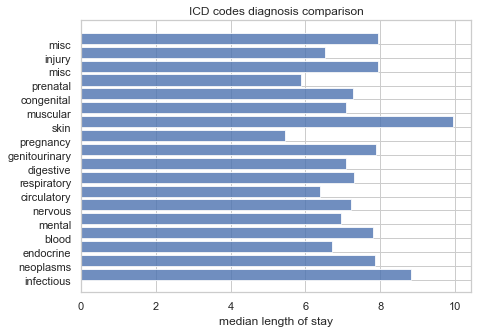

In [38]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(7,5))
ind = range(len(results))
ax.barh(ind, results, align='edge', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(list(diag_cat_dict.values()))
ax.set_xlabel('median length of stay')
ax.set_title('ICD codes diagnosis comparison')
plt.show()

#### ICUSTAYS table

In [39]:
ICUSTAYS = pd.read_csv('ICUSTAYS.csv')

In [40]:
ICUSTAYS.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,2.8939
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0600
4,369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,1.6202


In [41]:
print('Dataset has {} number of unique icu admissions.'.format(ICUSTAYS['HADM_ID'].nunique()))

Dataset has 57786 number of unique icu admissions.


In [42]:
ICUSTAYS['FIRST_CAREUNIT'].value_counts().index.tolist()

['MICU', 'CSRU', 'SICU', 'NICU', 'CCU', 'TSICU']

In [43]:
ICUSTAYS['FIRST_CAREUNIT'].replace({'CCU': 'ICU', 'CSRU': 'ICU', 'MICU': 'ICU',
                                  'SICU': 'ICU', 'TSICU': 'ICU'}, inplace=True)

In [44]:
ICUSTAYS['FIRST_CAREUNIT'].value_counts().index.tolist()

['ICU', 'NICU']

In [45]:
ICUSTAYS['FIRST_CAREUNIT'].value_counts()

ICU     53432
NICU     8100
Name: FIRST_CAREUNIT, dtype: int64

In [46]:
ICUSTAYS['CAT'] = ICUSTAYS['FIRST_CAREUNIT']
ICUSTAYS_CAT_Lst = ICUSTAYS.groupby('HADM_ID')['CAT'].apply(list).reset_index()
ICUSTAYS_CAT_Lst.head()

,HADM_ID,CAT
0,100001,[ICU]
1,100003,[ICU]
2,100006,[ICU]
3,100007,[ICU]
4,100009,[ICU]


In [47]:
ICU_type_split = pd.get_dummies(ICUSTAYS_CAT_Lst['CAT'].apply(pd.Series).stack()).sum(level=0)
ICU_type_split[ICU_type_split >= 1] = 1

In [48]:
ICU_type_split = ICU_type_split.join(ICUSTAYS_CAT_Lst['HADM_ID'], how="outer")
ICU_type_split.head()

,ICU,NICU,HADM_ID
0,1,0,100001
1,1,0,100003
2,1,0,100006
3,1,0,100007
4,1,0,100009


In [49]:
ICU_type_split.ICU.sum()

49794

In [50]:
ICU_type_split.NICU.sum()

7992

In [51]:
ADMISSIONS = ADMISSIONS.merge(ICU_type_split, how='outer', on='HADM_ID')

In [52]:
ADMISSIONS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58962 entries, 0 to 58961
Data columns (total 41 columns):
ROW_ID                  58878 non-null float64
SUBJECT_ID              58878 non-null float64
HADM_ID                 58962 non-null int64
ADMITTIME               58878 non-null datetime64[ns]
DISCHTIME               58878 non-null datetime64[ns]
DEATHTIME               5774 non-null object
ADMISSION_TYPE          58878 non-null object
ADMISSION_LOCATION      58878 non-null object
DISCHARGE_LOCATION      58878 non-null object
INSURANCE               58878 non-null object
LANGUAGE                33606 non-null object
RELIGION                58426 non-null object
MARITAL_STATUS          48781 non-null object
ETHNICITY               58878 non-null object
EDREGTIME               30821 non-null object
EDOUTTIME               30821 non-null object
DIAGNOSIS               58853 non-null object
HOSPITAL_EXPIRE_FLAG    58878 non-null float64
HAS_CHARTEVENTS_DATA    58878 non-null float64

In [53]:
ADMISSIONS.ICU.value_counts(dropna=False)

1.0    49794
0.0     7992
NaN     1176
Name: ICU, dtype: int64

In [54]:
ADMISSIONS.NICU.value_counts(dropna=False)

0.0    49794
1.0     7992
NaN     1176
Name: NICU, dtype: int64

In [55]:
ADMISSIONS['ICU'].fillna(value=0, inplace=True)
ADMISSIONS['NICU'].fillna(value=0, inplace=True)

In [56]:
ADMISSIONS.ICU.value_counts(dropna=False)

1.0    49794
0.0     9168
Name: ICU, dtype: int64

In [57]:
ADMISSIONS.NICU.value_counts(dropna=False)

0.0    50970
1.0     7992
Name: NICU, dtype: int64

In [58]:
ADMISSIONS.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,ICU,NICU
0,21.0,22.0,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,22.0,23.0,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,23.0,23.0,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,24.0,24.0,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,25.0,25.0,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### Patients table

In [59]:
PATIENTS = pd.read_csv('PATIENTS.csv')

In [60]:
PATIENTS.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


In [61]:
PATIENTS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46520 entries, 0 to 46519
Data columns (total 8 columns):
ROW_ID         46520 non-null int64
SUBJECT_ID     46520 non-null int64
GENDER         46520 non-null object
DOB            46520 non-null object
DOD            15759 non-null object
DOD_HOSP       9974 non-null object
DOD_SSN        13378 non-null object
EXPIRE_FLAG    46520 non-null int64
dtypes: int64(3), object(5)
memory usage: 2.8+ MB


In [62]:
PATIENTS['GENDER'].value_counts()

M    26121
F    20399
Name: GENDER, dtype: int64

In [63]:
PATIENTS['DOB'] = pd.to_datetime(PATIENTS['DOB'])

In [64]:
PATIENTS.drop(columns=['ROW_ID','DOD_HOSP','DOD_SSN',
                       'EXPIRE_FLAG','DOD'], inplace=True)
#PATIENTS = PATIENTS[['SUBJECT_ID', 'DOB', 'GENDER']]

In [65]:
PATIENTS.head()

,SUBJECT_ID,GENDER,DOB
0,249,F,2075-03-13
1,250,F,2164-12-27
2,251,M,2090-03-15
3,252,M,2078-03-06
4,253,F,2089-11-26


In [66]:
ADMISSIONS = ADMISSIONS.merge(PATIENTS, how='inner', on='SUBJECT_ID')

In [67]:
ADMISSIONS.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,ICU,NICU,GENDER,DOB
0,21.0,22.0,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,F,2131-05-07
1,22.0,23.0,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,M,2082-07-17
2,23.0,23.0,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,M,2082-07-17
3,24.0,24.0,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,M,2100-05-31
4,25.0,25.0,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,M,2101-11-21


#### Calculate age for each patient using DOB from new admission table.

In [68]:
AGE = ADMISSIONS[['SUBJECT_ID', 'ADMITTIME']].groupby('SUBJECT_ID').min().reset_index()
AGE.columns = ['SUBJECT_ID', 'ADMITTIME_earliest']
AGE.head()


,SUBJECT_ID,ADMITTIME_earliest
0,2.0,2138-07-17 19:04:00
1,3.0,2101-10-20 19:08:00
2,4.0,2191-03-16 00:28:00
3,5.0,2103-02-02 04:31:00
4,6.0,2175-05-30 07:15:00


In [69]:
ADMISSIONS = ADMISSIONS.merge(AGE, how='outer', on='SUBJECT_ID')

In [70]:
ADMISSIONS.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,nervous,pregnancy,prenatal,respiratory,skin,ICU,NICU,GENDER,DOB,ADMITTIME_earliest
0,21.0,22.0,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,F,2131-05-07,2196-04-09 12:26:00
1,22.0,23.0,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,M,2082-07-17,2153-09-03 07:15:00
2,23.0,23.0,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,M,2082-07-17,2153-09-03 07:15:00
3,24.0,24.0,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,M,2100-05-31,2139-06-06 16:14:00
4,25.0,25.0,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,M,2101-11-21,2160-11-02 02:06:00


In [71]:
ADMISSIONS['ADMITTIME_earliest'] = pd.to_datetime(ADMISSIONS['ADMITTIME_earliest'])

In [72]:
ADMISSIONS['DOB'] = pd.to_datetime(ADMISSIONS['DOB'])

def change(x):
    return x.date()

ADMISSIONS['ADMITTIME_earliest'] = ADMISSIONS['ADMITTIME_earliest'].apply(change)


In [73]:
#ADMISSIONS['age'] = ((ADMISSIONS['ADMITTIME_earliest'] - ADMISSIONS['DOB']).dt.days) // 365
ADMISSIONS['age'] = ADMISSIONS['ADMITTIME_earliest'].subtract(ADMISSIONS['DOB']).dt.days // 365

ADMISSIONS['age'] = np.where(ADMISSIONS['age'] < 0, 90, ADMISSIONS['age'])
ADMISSIONS['age'] = np.where(ADMISSIONS['age'] == -0, 0, ADMISSIONS['age'])

In [74]:
print('There are {} null value in AGE in this dataset.'.format(ADMISSIONS['age'].isnull().sum()))

There are 0 null value in AGE in this dataset.


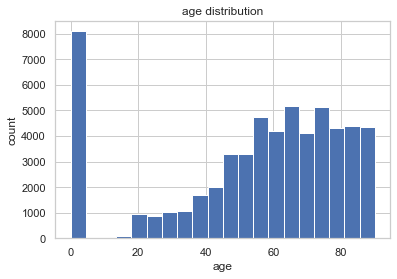

In [75]:
plt.hist(ADMISSIONS['age'], bins=20)
plt.ylabel('count')
plt.xlabel('age')
plt.title('age distribution')
plt.tick_params(left=False, bottom=False, top=False, right=False) 
plt.show()

In [76]:
Age_range = [(0, 13), (13, 36), (36, 56), (56, 100)]
for i, range_ in enumerate(Age_range):
    ADMISSIONS['age'] = np.where(ADMISSIONS['age'].between(range_[0],range_[1]), 
            i, ADMISSIONS['age'])
    
cat = {0: 'newborn', 1: 'young_adult', 2: 'middle_adult', 3: 'senior'}
ADMISSIONS['age'] = ADMISSIONS['age'].replace(cat)
ADMISSIONS.age.value_counts()

senior          33785
middle_adult    12732
newborn          8101
young_adult      4260
Name: age, dtype: int64

def plot(INPUT):
    results = ADMISSIONS[[INPUT, 'LOS']].groupby(INPUT).median().reset_index()
    values = list(results['LOS'].values)
    labels = list(results[INPUT].values)

    fig, ax = plt.subplots(figsize=(7,4))
    ind = range(len(results))
    ax.barh(ind, values, align='center', height=0.6, alpha=0.8)
    ax.set_yticks(ind)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Median Length of Stay')
    ax.tick_params(left=False, top=False, right=False) 
    ax.set_title('Comparison of {} labels'.format(INPUT))
    plt.tight_layout()
    plt.show()

In [77]:
def boxplot(INPUT):
    results = ADMISSIONS[[INPUT, 'LOS']].groupby(INPUT).median().reset_index()
    print(results)

    data = []
    for i in results[INPUT].values.tolist():
        data.append(ADMISSIONS['LOS'].loc[ADMISSIONS[INPUT]==i].values)
    print(data)

    fig, ax = plt.subplots(figsize=(8,4))
    ax.boxplot(data, 0, '', vert=False)
    ax.set_xlim((0, 40))
    ax.set_yticklabels(results[INPUT].values.tolist())
    ax.set_xlabel('length of Stay')
    ax.tick_params(left=False, right=False) 
    ax.set_title('comparison of {}'.format(INPUT))
    
    plt.show()

  GENDER       LOS
0      F  6.456944
1      M  6.509375
[array([ 1.14444444,  2.68680556, 10.17708333, ..., 10.79444444,
        2.74236111,  0.54861111]), array([5.49652778, 6.76805556, 2.85694444, ..., 4.14583333, 0.6625    ,
       8.20347222])]


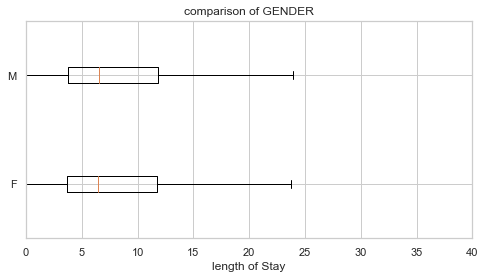

In [78]:
boxplot('GENDER')
ADMISSIONS['GENDER'].replace({'M': 0, 'F':1}, inplace=True)

EMERGENCY    41989
NEWBORN       7854
ELECTIVE      7702
URGENT        1333
Name: ADMISSION_TYPE, dtype: int64
  ADMISSION_TYPE       LOS
0       ELECTIVE  6.323958
1      EMERGENCY  6.905556
2        NEWBORN  4.097917
3         URGENT  8.114583
[array([ 5.49652778,  5.36458333, 19.19791667, ...,  0.32708333,
        4.14583333,  8.20347222]), array([1.14444444, 6.76805556, 2.85694444, ..., 0.6625    , 2.74236111,
       0.54861111]), array([2.68680556, 9.75416667, 4.14930556, ..., 3.89652778, 2.54027778,
       2.07777778]), array([ 5.01388889,  9.09375   ,  7.09166667, ...,  1.14930556,
        7.94236111, 11.90694444])]


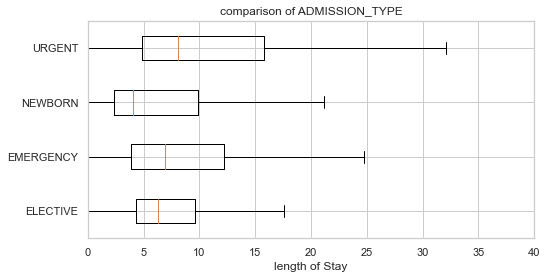

In [79]:
print(ADMISSIONS['ADMISSION_TYPE'].value_counts())
boxplot('ADMISSION_TYPE')

MARRIED              24199
SINGLE               13238
UNKNOWN (DEFAULT)    10440
WIDOWED               7204
DIVORCED              3211
SEPARATED              571
LIFE PARTNER            15
Name: MARITAL_STATUS, dtype: int64
      MARITAL_STATUS       LOS
0           DIVORCED  7.226389
1       LIFE PARTNER  6.083333
2            MARRIED  6.943750
3          SEPARATED  7.384028
4             SINGLE  6.472569
5  UNKNOWN (DEFAULT)  4.337500
6            WIDOWED  7.081597
[array([10.17708333,  7.94305556,  0.52083333, ...,  7.09097222,
        5.97638889,  3.77013889]), array([ 3.11111111,  4.55277778,  6.08333333,  6.93194444,  7.00277778,
       10.45416667,  1.27916667, 14.80277778,  2.80763889, 11.76111111,
        5.18055556, 27.95138889,  5.86736111,  4.09652778,  6.75694444]), array([ 1.14444444,  5.49652778,  6.76805556, ..., 10.57291667,
        4.14583333,  8.20347222]), array([ 10.58819444,   3.91388889,   4.7875    ,   3.81527778,
         2.79444444,   3.81111111,   7.40763889,

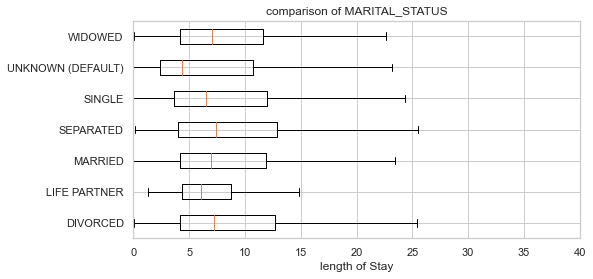

In [80]:
ADMISSIONS['MARITAL_STATUS'] = ADMISSIONS['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')
ADMISSIONS['MARITAL_STATUS'].value_counts(dropna=False)
print(ADMISSIONS['MARITAL_STATUS'].value_counts())
boxplot('MARITAL_STATUS')

Medicare      28174
Private       22542
Medicaid       5778
Government     1781
Self Pay        603
Name: INSURANCE, dtype: int64
    INSURANCE       LOS
0  Government  5.525694
1    Medicaid  6.176736
2    Medicare  7.151042
3     Private  5.689236
4    Self Pay  4.033333
[array([ 1.94305556, 24.48611111,  4.66180556, ...,  0.64236111,
        4.90208333,  4.57847222]), array([19.19791667, 15.15      ,  6.49166667, ...,  5.06458333,
        4.36319444,  2.68055556]), array([5.49652778, 6.76805556, 6.98888889, ..., 4.14583333, 0.6625    ,
       0.54861111]), array([ 1.14444444,  2.85694444,  3.53402778, ..., 10.57291667,
        2.74236111,  8.20347222]), array([3.50833333e+00, 4.98680556e+00, 1.01097222e+01, 4.02777778e-01,
       3.08472222e+00, 5.15277778e-01, 2.60902778e+00, 3.15972222e+00,
       1.90138889e+00, 5.28472222e-01, 7.15972222e-01, 2.42222222e+00,
       6.03333333e+00, 2.84444444e+00, 6.82083333e+00, 6.18888889e+00,
       1.64583333e+01, 4.10000000e+00, 1.40187500e+

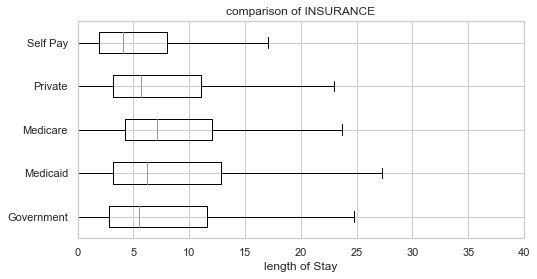

In [81]:
print(ADMISSIONS['INSURANCE'].value_counts())
boxplot('INSURANCE')

In [82]:
ADMISSIONS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58878 entries, 0 to 58877
Data columns (total 45 columns):
ROW_ID                  58878 non-null float64
SUBJECT_ID              58878 non-null float64
HADM_ID                 58878 non-null int64
ADMITTIME               58878 non-null datetime64[ns]
DISCHTIME               58878 non-null datetime64[ns]
DEATHTIME               5774 non-null object
ADMISSION_TYPE          58878 non-null object
ADMISSION_LOCATION      58878 non-null object
DISCHARGE_LOCATION      58878 non-null object
INSURANCE               58878 non-null object
LANGUAGE                33606 non-null object
RELIGION                58426 non-null object
MARITAL_STATUS          58878 non-null object
ETHNICITY               58878 non-null object
EDREGTIME               30821 non-null object
EDOUTTIME               30821 non-null object
DIAGNOSIS               58853 non-null object
HOSPITAL_EXPIRE_FLAG    58878 non-null float64
HAS_CHARTEVENTS_DATA    58878 non-null float64

In [83]:
# Drop the columns that we don't need anymore.
ADMISSIONS.drop(columns=['DISCHTIME', 'ROW_ID', 
                'EDREGTIME', 'EDOUTTIME', 'HOSPITAL_EXPIRE_FLAG',
                'HAS_CHARTEVENTS_DATA','LOS(ICU)'], inplace=True)

In [84]:
ADMISSIONS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58878 entries, 0 to 58877
Data columns (total 38 columns):
SUBJECT_ID            58878 non-null float64
HADM_ID               58878 non-null int64
ADMITTIME             58878 non-null datetime64[ns]
DEATHTIME             5774 non-null object
ADMISSION_TYPE        58878 non-null object
ADMISSION_LOCATION    58878 non-null object
DISCHARGE_LOCATION    58878 non-null object
INSURANCE             58878 non-null object
LANGUAGE              33606 non-null object
RELIGION              58426 non-null object
MARITAL_STATUS        58878 non-null object
ETHNICITY             58878 non-null object
DIAGNOSIS             58853 non-null object
LOS                   58878 non-null float64
DECEASED              58878 non-null float64
blood                 58878 non-null float64
circulatory           58878 non-null float64
congenital            58878 non-null float64
digestive             58878 non-null float64
endocrine             58878 non-null float

In [85]:
ADMISSIONS.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,...,pregnancy,prenatal,respiratory,skin,ICU,NICU,GENDER,DOB,ADMITTIME_earliest,age
0,22.0,165315,2196-04-09 12:26:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,...,0.0,0.0,0.0,0.0,1.0,0.0,1,2131-05-07,2196-04-09 12:26:00,senior
1,23.0,152223,2153-09-03 07:15:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,...,0.0,0.0,0.0,0.0,1.0,0.0,0,2082-07-17,2153-09-03 07:15:00,senior
2,23.0,124321,2157-10-18 19:34:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,...,0.0,1.0,0.0,0.0,1.0,0.0,0,2082-07-17,2153-09-03 07:15:00,senior
3,24.0,161859,2139-06-06 16:14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,...,0.0,0.0,0.0,0.0,1.0,0.0,0,2100-05-31,2139-06-06 16:14:00,middle_adult
4,25.0,129635,2160-11-02 02:06:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,...,0.0,0.0,0.0,0.0,1.0,0.0,0,2101-11-21,2160-11-02 02:06:00,senior


### Further pre-processing the data


In [86]:
# Removing people who died (Or not)
ADMISSIONS = ADMISSIONS[ADMISSIONS['DECEASED'] == 0]

# Removing negative length of stay
ADMISSIONS = ADMISSIONS[ADMISSIONS['LOS'] > 0]

In [87]:
ADMISSIONS.drop(columns=['SUBJECT_ID', 'HADM_ID', 
                         'ADMITTIME', 'ADMISSION_LOCATION',
                'DISCHARGE_LOCATION', 'LANGUAGE', 
                         'ADMITTIME_earliest', 'DOB',
                'DIAGNOSIS', 'DECEASED',  'DEATHTIME'],
                inplace=True)

In [88]:
ADMISSIONS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53104 entries, 0 to 58877
Data columns (total 27 columns):
ADMISSION_TYPE    53104 non-null object
INSURANCE         53104 non-null object
RELIGION          52743 non-null object
MARITAL_STATUS    53104 non-null object
ETHNICITY         53104 non-null object
LOS               53104 non-null float64
blood             53104 non-null float64
circulatory       53104 non-null float64
congenital        53104 non-null float64
digestive         53104 non-null float64
endocrine         53104 non-null float64
genitourinary     53104 non-null float64
infectious        53104 non-null float64
injury            53104 non-null float64
mental            53104 non-null float64
misc              53104 non-null float64
muscular          53104 non-null float64
neoplasms         53104 non-null float64
nervous           53104 non-null float64
pregnancy         53104 non-null float64
prenatal          53104 non-null float64
respiratory       53104 non-null fl

In [89]:
# Create dummy columns for categorical variables
prefixs = ['ADM', 'INS', 'REL', 'ETH', 'AGE', 'MAR', 'RELIGION']
dummy_columns = ['ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
             'ETHNICITY', 'age', 'MARITAL_STATUS', 'RELIGION']

ADMISSIONS = pd.get_dummies(ADMISSIONS, prefix=prefixs, columns=dummy_columns)


In [90]:
ADMISSIONS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53104 entries, 0 to 58877
Columns: 122 entries, LOS to RELIGION_UNOBTAINABLE
dtypes: float64(20), int64(1), uint8(101)
memory usage: 14.0 MB


In [91]:
ADMISSIONS.head(10)

,LOS,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,...,RELIGION_JEWISH,RELIGION_LUTHERAN,RELIGION_METHODIST,RELIGION_MUSLIM,RELIGION_NOT SPECIFIED,RELIGION_OTHER,RELIGION_PROTESTANT QUAKER,RELIGION_ROMANIAN EAST. ORTH,RELIGION_UNITARIAN-UNIVERSALIST,RELIGION_UNOBTAINABLE
0,1.144444,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,...,0,0,0,0,0,0,0,0,0,1
1,5.496528,0.0,4.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,6.768056,0.0,2.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,2.856944,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
4,3.534028,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
5,6.988889,0.0,5.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
6,2.686806,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7,5.364583,0.0,4.0,0.0,0.0,2.0,0.0,0.0,3.0,1.0,...,0,0,0,0,0,0,0,0,0,0
8,5.013889,0.0,6.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
10,19.197917,0.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [109]:
#ADMISSIONS.to_csv('AD.csv')

### Model

In [92]:
LOS = ADMISSIONS['LOS'].values
# Prediction Features
features = ADMISSIONS.drop(columns=['LOS'])

In [93]:
# Split into train 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    LOS, 
                                                    test_size = .20, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 42483 samples.
Testing set has 10621 samples.


In [110]:
X_train.head()

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,...,RELIGION_JEWISH,RELIGION_LUTHERAN,RELIGION_METHODIST,RELIGION_MUSLIM,RELIGION_NOT SPECIFIED,RELIGION_OTHER,RELIGION_PROTESTANT QUAKER,RELIGION_ROMANIAN EAST. ORTH,RELIGION_UNITARIAN-UNIVERSALIST,RELIGION_UNOBTAINABLE
33174,1.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
39700,2.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0,0,0,0,0,0,1,0,0,0
10562,0.0,3.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
52457,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
57477,1.0,1.0,0.0,1.0,2.0,0.0,0.0,2.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
type(X_train)

pandas.core.frame.DataFrame

In [95]:
# Regression models for comparison
models = [SGDRegressor(random_state = 0), 
          GradientBoostingRegressor(random_state = 0), 
          LinearRegression(),
          KNeighborsRegressor(),
          RandomForestRegressor(random_state = 0)]

results = {}
for model in models:
    reg_model = model
    reg_model.fit(X_train, y_train)
    
    y_test_preds = reg_model.predict(X_test)
    name = str(model).split("(")[0]

    results[name] = r2_score(y_test, y_test_preds)
    print('{} done.'.format(name))

SGDRegressor done.
GradientBoostingRegressor done.
LinearRegression done.
KNeighborsRegressor done.


/Users/pan/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor done.


In [111]:
results

{'SGDRegressor': 0.29908727150779857,
 'GradientBoostingRegressor': 0.3580375597740202,
 'LinearRegression': 0.30138115999979376,
 'KNeighborsRegressor': 0.2692540844100415,
 'RandomForestRegressor': 0.27803866252893417}

Text(0.5, 1.0, 'Regression Models Comparison')

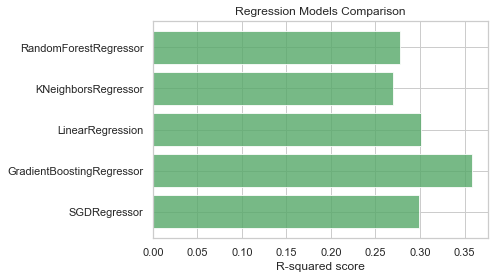

In [96]:
fig, ax = plt.subplots()
ind = range(len(results))
ax.barh(ind, list(results.values()), align='center', 
        color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(results.keys())
ax.set_xlabel('R-squared score')
ax.tick_params(left=False, top=False, right=False) 
ax.set_title('Regression Models Comparison')

In [97]:
reg_model = GradientBoostingRegressor(random_state=0)   
reg_model.fit(X_train, y_train)
y_test_preds = reg_model.predict(X_test)
r2_not_refined = r2_score(y_test, y_test_preds)
print("R2 score is: {:2f}".format(r2_not_refined))

R2 score is: 0.358038


In [98]:
#ADMISSIONS.to_csv('wholefile.csv')

In [99]:
Train_Data = pd.read_csv('static_train_data.csv')
Train_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23392 entries, 0 to 23391
Data columns (total 63 columns):
Unnamed: 0                   23392 non-null int64
subject_id                   23392 non-null int64
hadm_id                      23392 non-null int64
icustay_id                   23392 non-null int64
anytime_expire_flag          23392 non-null int64
hospital_expire_flag         23392 non-null int64
icu_expire_flag              23392 non-null int64
time_of_death                9153 non-null object
time_until_death             9153 non-null object
hours_until_death            23392 non-null float64
days_until_death             9153 non-null float64
admittime                    23392 non-null object
dischtime                    23392 non-null object
intime                       23392 non-null object
outtime                      23391 non-null object
time_until_hospital_exit     23392 non-null object
days_until_hospital_exit     23392 non-null float64
admission_time_until_icu     23

In [100]:
Train_Data.head()

,Unnamed: 0,subject_id,hadm_id,icustay_id,anytime_expire_flag,hospital_expire_flag,icu_expire_flag,time_of_death,time_until_death,hours_until_death,...,organ,blood,acute,failure,cancer,back,bone,pain,other,totalcats
0,0,87995,160147,262215,1,0,0,2195-10-08 00:00:00,20 days 09:46:34,489.0,...,0,1,0,0,0,0,0,0,0,2
1,1,28546,100408,213952,0,0,0,NaN,NaN,103018.0,...,0,0,0,0,0,0,0,0,0,1
2,2,86648,121994,249762,0,0,0,NaN,NaN,103018.0,...,0,0,0,0,0,0,0,0,0,1
3,3,52087,129686,214231,0,0,0,NaN,NaN,103018.0,...,0,1,0,0,0,0,0,0,0,2
4,4,77625,181740,205631,0,0,0,NaN,NaN,103018.0,...,0,0,0,0,0,0,0,0,1,0


In [101]:
LOS = Train_Data['hours_until_leave_ICU'].values

In [102]:
LOS

array([ 54.,  27., 119., ...,  25., 311., 233.])

In [103]:
# Prediction Features
features = Train_Data[['cardio','infection','brain',
                       'mental','gastro','trauma','respiratory','organ','blood','acute','failure','cancer','back',
                       'bone','pain','other','totalcats']].values

In [104]:
features

array([[0, 0, 0, ..., 0, 0, 2],
       [1, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 2]])

In [105]:
# Regression models for comparison
models = [SGDRegressor(random_state = 0), 
          GradientBoostingRegressor(random_state = 0), 
          LinearRegression(),
          KNeighborsRegressor(),
          RandomForestRegressor(random_state = 0)]

In [106]:
for model in models:
    reg_model = model
    reg_model.fit(features, LOS)

/Users/pan/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
